In [268]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from func_tools import normalize, get_labels, cnn_data_reshaping, reshape_lob_levels, plot_labels, label_insights, get_pnl

import plotly_express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
#import tensorflow as tf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
security = 'USDT_BTC'
root_caching_folder = "Processed_Data"
frequency = timedelta(seconds=10)
norm_type = 'dyn_z_score'
model_name = 'dynz_score_lob_v3_10s'
trading_fee=0.000712

# labelling inputs
k_plus = 30#60
k_minus = 30#60
alpha = 0.001#0.0005
roll = 7200 * 6 # step from minute to 10 second data

In [3]:
data = pd.read_csv(f'{root_caching_folder}/{security}/data-cache-10s.csv', index_col=0)
lob_depth = data['Level'].max() + 1
train_test_split = int((data.shape[0] / lob_depth) * 0.7) # slice reference for train and test
test_timestamps = data['Datetime'].unique()[train_test_split:] # timestamps array
test_cached_data = data[data['Datetime'].isin(test_timestamps)].set_index(['Datetime', 'Level']) # split

In [4]:
# # Model predictions
# # Load the previously saved weights
# deep_lob_loaded = tf.keras.models.load_model(model_name)

# generator_test = TimeseriesGenerator(
#     test_depth_dyn,
#     encoded_test_labels,
#     100,
#     batch_size=64,
#     shuffle=False
# )

# # Re-evaluate the model
# loss, acc = deep_lob_loaded.evaluate(generator_test, verbose=2)
# print("Restored model, accuracy: {:5.2f}%".format(100*acc))

In [5]:
# import dynamically norm ts - reminder: it's shifted by the rolling window
# import cached dynamic roll normalization - to extract labels
test_dyn_df = pd.read_csv(f'{root_caching_folder}/{security}/TEST-{lob_depth}-{norm_type}-{roll}.csv')

test_dyn_df['Mid_Price'] = (test_dyn_df['Ask_Price'] + test_dyn_df['Bid_Price']) / 2

norm_mid_px = test_dyn_df.reset_index()['Mid_Price']
labels = get_labels(norm_mid_px, k_plus, k_minus, alpha, long_only=False)
# print out labels
label_insights(labels)

Labels shape: (430328,)
Labels: [-1  0  1] 
Count: [212514   8744 209070] 
Pctg: [0.49384191 0.02031938 0.48583871]
Number of total transaction: 13530


13530

In [340]:
# get pnl from normalized labels and real px timeseries (alway postive prices)
roll_shift = (7200*6)+1 # rolling period for dyn z score - + 1 from shift in ft.normalize
top_ob = test_cached_data[test_cached_data.index.get_level_values(1)==0][roll_shift:]
top_ob['Mid_Price'] = (top_ob['Ask_Price'] + top_ob['Bid_Price']) / 2
top_ob['Spread'] = (top_ob['Ask_Price'] - top_ob['Bid_Price']) / top_ob['Mid_Price']
mid_px = top_ob.reset_index()['Mid_Price']

# get pnl dataframe
pnl_simulated, df_simulated, idx_simulated = get_pnl(mid_px, labels, trading_fee=0.000712)

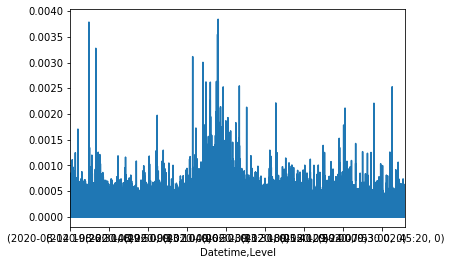

In [341]:
top_ob['Spread'].plot()

In [342]:
# mid px linechart - sampled
hourly_mid_line = go.Figure()
hourly_mid_line.add_trace(go.Scatter(y=mid_px.iloc[::6*60].values, name='mid'))

hourly_mid_line.update_layout(title='<b>Hourly sampled mid</b>')
hourly_mid_line.show()

In [31]:
# isolate one trade - use label changes or idx V
# calculate pnl for that trade - with reinvest or not reinvest
# average length trade V
# percentage of winning trades V
# long and shorts V

# also return bid and ask from get_pnl function
# sharpe ratio strategy or other useful metrics
# only enter trades with a certain level of certainty (need to use predictions)

# costs
# transaction costs: fixed, already included V
# "slippage": incorporate when realistically you would actually enter the trade - 1 period lag? Average between current period and next period level
# spread: you'll likely buy at ask and sell at bid, not at mid
# slippage: have a size in mind as an input and see how that would work against spread for a certain mkt depth

# further improvements
# improve with risk management (do not enter a trade unless confortable with risk)
# efficient execution system

In [185]:
# test1 = df_simulated[idx_simulated[0]:idx_simulated[1]+1]
# ((test1['px'].values[-1] - test1['px'].values[0])/test1['px'].values[0]) * test1['labels'].values[0]

In [444]:
start_idx

array([     0,     29,     53, ..., 430220, 430279, 430280])

In [504]:
df = df_simulated[3455:3568]
df = df_simulated[29:53]
df

,px,labels,return,realized_return,trade_flag,pnl,Datetime,Level,Ask_Price,Ask_Size,Bid_Price,Bid_Size,Mid_Price,Spread
29,11810.599211,1,1.693312e-12,1.693312e-12,True,1.000000,2020-08-14 19:31:20,0,11810.997510,2.017340,11810.200911,1.983020,11810.599211,6.744773e-05
30,11810.997480,1,3.372137e-05,3.372137e-05,False,1.000034,2020-08-14 19:31:30,0,11810.997480,1.999658,11810.997480,2.054369,11810.997480,8.467366e-13
31,11811.519302,1,4.418102e-05,4.418102e-05,False,1.000078,2020-08-14 19:31:40,0,11812.041124,1.999823,11810.997480,0.058531,11811.519302,8.835813e-05
32,11811.519302,1,-1.269873e-12,-1.269873e-12,False,1.000078,2020-08-14 19:31:50,0,11812.041124,0.031229,11810.997480,1.995153,11811.519302,8.835813e-05
33,11807.564494,1,-3.348264e-04,-3.348264e-04,False,0.999743,2020-08-14 19:32:00,0,11809.131507,2.000000,11805.997480,0.002611,11807.564494,2.654254e-04
34,11807.359731,1,-1.734162e-05,-1.734162e-05,False,0.999726,2020-08-14 19:32:10,0,11809.131507,2.000000,11805.587955,2.000000,11807.359731,3.001138e-04
35,11807.950107,1,5.000063e-05,5.000063e-05,False,0.999776,2020-08-14 19:32:20,0,11809.131507,2.166944,11806.768706,0.055534,11807.950107,2.001025e-04
36,11807.950107,1,3.387735e-12,3.387735e-12,False,0.999776,2020-08-14 19:32:30,0,11809.131507,2.000000,11806.768706,0.020082,11807.950107,2.001025e-04
37,11807.950107,1,-1.693867e-12,-1.693867e-12,False,0.999776,2020-08-14 19:32:40,0,11809.131507,2.031132,11806.768706,0.054955,11807.950107,2.001025e-04
38,11807.950107,1,1.270317e-12,1.270317e-12,False,0.999776,2020-08-14 19:32:50,0,11809.131507,2.031483,11806.768706,0.020550,11807.950107,2.001025e-04


In [505]:
start_px = df['px'].values[0]
end_px = df['px'].values[-1]
trade_type = df['labels'].values[0]
(((end_px - (end_px*trading_fee)) - (start_px+(start_px*trading_fee)))/(start_px+(start_px*trading_fee))) * trade_type # buy trade

-0.001185640345019161

In [509]:
df['Ask_Price'].values[-1], df['Ask_Price'].values[-3]

(11814.42953288, 11817.38328584)

In [482]:
start_px = df['Ask_Price'].values[0]
end_px = df['Bid_Price'].values[-1]
trade_type = df['labels'].values[0]
(((end_px - (end_px*trading_fee)) - (start_px+(start_px*trading_fee)))/(start_px+(start_px*trading_fee))) * trade_type # buy trade

-0.0013058244736774871

In [465]:
start_px = df['px'].values[0]
end_px = df['px'].values[-1]
trade_type = df['labels'].values[0]
((end_px - start_px)/start_px) * trade_type 

0.0007815013017090633

In [476]:
df_simulated = pd.merge(df_simulated, top_ob.reset_index(), left_index=True, right_index=True)

In [511]:
#idx_simulated_shifted = np.concatenate((0, idx_simulated[1:], np.array([df_simulated.shape[0]])))
start_idx = np.concatenate((np.array([0]), idx_simulated[:-1]))
end_idx = idx_simulated
trades = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0]) # initiate an array with 4 values - number of columns

def calculate_return(start_px, end_px, trade_type, trading_fee):
    if trade_type == 1:
        pctg_chg = (((end_px - (end_px*trading_fee)) - (start_px+(start_px*trading_fee)))/(start_px+(start_px*trading_fee))) * trade_type # buy trade
    elif trade_type == -1:
        pctg_chg = (((end_px + (end_px*trading_fee)) - (start_px-(start_px*trading_fee)))/(start_px-(start_px*trading_fee))) * trade_type # sell trade
    else:
        pctg_chg = 0 # neutral

    return pctg_chg

# loop through each trade
for start_trade, end_trade in zip(start_idx, end_idx):

    df = df_simulated[start_trade:end_trade] # slice of with single trade
    trade_type = df['labels'].values[0] # direction from first label
    start_mid_px = df['Mid_Price'].values[0]
    end_mid_px = df['Mid_Price'].values[-1]
    start_ask_px = df['Ask_Price'].values[0]
    end_ask_px = df['Ask_Price'].values[-1]
    start_bid_px = df['Bid_Price'].values[0]
    end_bid_px = df['Bid_Price'].values[-1]

    start_mid_px_slip = df['Mid_Price'].values[1]
    end_mid_px_slip = df['Mid_Price'].values[-2]
    start_ask_px_slip = df['Ask_Price'].values[1]
    end_ask_px_slip = df['Ask_Price'].values[-2]
    start_bid_px_slip = df['Bid_Price'].values[1]
    end_bid_px_slip = df['Bid_Price'].values[-2]

    gross_trade_return = calculate_return(start_mid_px, end_mid_px, trade_type, 0) # gross performance
    
    net_fees_return = calculate_return(start_mid_px, end_mid_px, trade_type, trading_fee) # net trading fee performance (entry and exit)

    net_slippage_return = calculate_return((start_mid_px + end_mid_px_slip)/2, (end_mid_px + end_mid_px_slip)/2, trade_type, 0) # gross minus slippage only using mid

    if trade_type == 1:
        net_bbo_spread_return = calculate_return(start_ask_px, end_bid_px, trade_type, 0) # net of bbo spread performance (round-trip)
        net_return = calculate_return((start_ask_px + start_ask_px_slip)/2, (end_bid_px + end_bid_px_slip)/2, trade_type, trading_fee) # net return all-in
    elif trade_type == -1:
        net_bbo_spread_return = calculate_return(start_bid_px, end_ask_px, trade_type, 0) # net of bbo spread performance (round-trip)
        net_return = calculate_return((start_bid_px + start_bid_px_slip)/2, (end_ask_px + end_ask_px_slip)/2, trade_type, trading_fee) # net return all-in
    elif trade_type == 0:
        net_bbo_spread_return = gross_trade_return # 0
        net_return = gross_trade_return # 0

    net_fees_return = gross_trade_return - (trading_fee * abs(trade_type))
    trades = np.vstack([trades, np.array([start_trade, end_trade, start_mid_px, end_mid_px, start_ask_px, end_ask_px, start_bid_px, end_bid_px, 
                        trade_type, gross_trade_return, net_fees_return, net_bbo_spread_return, net_slippage_return, net_return])])

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
# need to use next dataframe for slippage on selling
# handle trades with length of 1

In [499]:
df_trades_all = pd.DataFrame(trades, columns=['start_trade', 'end_trade', 'start_mid_px', 'end_mid_px','start_ask_px','end_ask_px','start_bid_px','end_bid_px', 'direction', 'gross_trade_return', 'net_trade_return', 'net_bbo_spread_return'])
df_trades_all['trade_length'] = df_trades_all['end_trade'] - df_trades_all['start_trade'] # how many periods a trade lasts
df_trades_all['winning_net_trades'] = df_trades_all.apply(lambda x: 1 if x['net_trade_return']>0 else (-1 if x['net_trade_return']<0 else 0), axis=1) # flag for winning trades
# trades without "zeros" - used to calculate stats
df_trades_in = df_trades_all[df_trades_all['direction'] != 0]
df_trades_in['trade_length'].describe()

count    8580.000000
mean       49.135664
std        38.094015
min         1.000000
25%        24.000000
50%        40.000000
75%        65.000000
max       308.000000
Name: trade_length, dtype: float64

In [500]:
df_trades_all[100:150]#.head(40)

,start_trade,end_trade,start_mid_px,end_mid_px,start_ask_px,end_ask_px,start_bid_px,end_bid_px,direction,gross_trade_return,net_trade_return,net_bbo_spread_return,trade_length,winning_net_trades
100,3375.0,3409.0,11862.406866,11849.210722,11862.406866,11849.810190,11862.406866,11848.611255,-1.0,0.001112,0.000400,0.001062,34.0,1
101,3409.0,3410.0,11848.914492,11848.914492,11849.217729,11849.217729,11848.611255,11848.611255,0.0,0.000000,0.000000,0.000000,1.0,0
102,3410.0,3454.0,11848.618269,11866.506688,11848.625284,11866.506688,11848.611255,11866.506688,1.0,0.001510,0.000798,0.001509,44.0,1
103,3454.0,3455.0,11866.506688,11866.506688,11866.506688,11866.506688,11866.506688,11866.506688,0.0,0.000000,0.000000,0.000000,1.0,0
104,3455.0,3568.0,11866.506688,11840.360311,11866.506688,11840.850438,11866.506688,11839.870185,-1.0,0.002203,0.001491,0.002162,113.0,1
105,3568.0,3569.0,11839.768357,11839.768357,11840.850438,11840.850438,11838.686277,11838.686277,0.0,0.000000,0.000000,0.000000,1.0,0
106,3569.0,3633.0,11839.472363,11864.480962,11840.258449,11865.016291,11838.686277,11863.945633,1.0,0.002112,0.001400,0.002001,64.0,1
107,3633.0,3634.0,11864.480962,11864.480962,11865.016291,11865.016291,11863.945633,11863.945633,0.0,0.000000,0.000000,0.000000,1.0,0
108,3634.0,3650.0,11863.945633,11859.373281,11863.945633,11860.663326,11863.945633,11858.083237,-1.0,0.000385,-0.000327,0.000277,16.0,-1
109,3650.0,3651.0,11858.083237,11858.083237,11858.083237,11858.083237,11858.083237,11858.083237,0.0,0.000000,0.000000,0.000000,1.0,0


In [ ]:
# to do: check if need to add double fees
# check discrepancies between gross and net
# not sure you can just add trading fees subtracting. Cumpounding effects?
# maybe that's behind discrepancies with pnl function?

In [443]:
(df_trades_['net_trade_return']+1).cumprod()

2           0.999526
4           1.000616
6           1.001265
7           1.001674
8           1.002727
            ...     
13522    9624.844979
13524    9626.177908
13526    9625.662504
13528    9624.667571
13530    9621.687361
Name: net_trade_return, Length: 8580, dtype: float64

In [442]:
(df_trades_all['gross_trade_return']+1).cumprod()

0        1.000000e+00
1        1.000000e+00
2        1.000238e+00
3        1.000238e+00
4        1.002041e+00
             ...     
13526    4.286764e+06
13527    4.286764e+06
13528    4.289373e+06
13529    4.289373e+06
13530    4.291099e+06
Name: gross_trade_return, Length: 13531, dtype: float64

In [406]:
((df_trades_all['pct_chg'] * (1 - 0.000712)) + 1).cumprod()

0        1.000000e+00
1        1.000238e+00
2        1.000238e+00
3        1.002040e+00
4        1.002040e+00
             ...     
13525    4.240509e+06
13526    4.240509e+06
13527    4.243088e+06
13528    4.243088e+06
13529    4.244794e+06
Name: pct_chg, Length: 13530, dtype: float64

In [361]:
df_trades_all.head(30)

,start,end,direction,start_px,end_px,pct_chg,trade_length,winning_trades
0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0
1,29.0,53.0,1.0,11810.599211,11813.406409,0.000238,24.0,1
2,53.0,54.0,0.0,11812.765804,11812.765804,0.000000,1.0,0
3,54.0,132.0,-1.0,11812.765804,11791.468131,0.001803,78.0,0
4,132.0,133.0,0.0,11790.828567,11790.828567,0.000000,1.0,0
5,133.0,156.0,1.0,11792.158483,11808.196587,0.001360,23.0,1
6,156.0,183.0,-1.0,11808.937300,11795.695455,0.001121,27.0,0
7,183.0,261.0,1.0,11795.695455,11816.483438,0.001762,78.0,1
8,261.0,337.0,-1.0,11816.483348,11765.922626,0.004279,76.0,0
9,337.0,338.0,0.0,11765.922626,11765.922626,0.000000,1.0,0


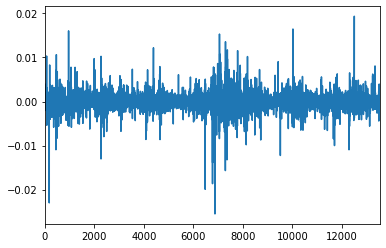

In [327]:
(df_trades_all['pct_chg'] * df_trades_all['direction']).plot()

In [321]:
df_trades_in

,start,end,direction,start_px,end_px,pct_chg,trade_length,winning_trades
1,29.0,53.0,1.0,11655.279272,11639.933886,-0.001317,24.0,0
3,54.0,132.0,-1.0,11641.603062,11631.071841,0.000905,78.0,0
5,133.0,156.0,1.0,11631.071841,11637.845431,0.000582,23.0,1
6,156.0,183.0,-1.0,11641.339536,11628.090365,0.001138,27.0,0
7,183.0,261.0,1.0,11628.090365,11636.984775,0.000765,78.0,1
...,...,...,...,...,...,...,...,...
13521,430042.0,430079.0,-1.0,10881.241586,10911.103795,-0.002744,37.0,1
13523,430081.0,430153.0,1.0,10909.826515,10897.476246,-0.001132,72.0,0
13525,430154.0,430213.0,-1.0,10897.476246,10894.934236,0.000233,59.0,0
13527,430220.0,430279.0,1.0,10887.323934,10872.640590,-0.001349,59.0,0


In [218]:
# Plot long short trades distributions
hist_trade_length = px.histogram(df_trades_in, x='trade_length', color='direction', title='<b>Trade length</b>')
hist_trade_length.show()

hist_trade_pctg_chg = px.histogram(df_trades_in, x='pct_chg', color='direction', title='<b>Trade pctg change</b>')
hist_trade_pctg_chg.show()
#fig.update_layout(barmode='overlay')

In [241]:
# Percentage of winning trades
pctg_winning_trades = df_trades_in['winning_trades'].sum() / df_trades_in.shape[0]

winning_df = df_trades_in[df_trades_in['pct_chg']>0]
losing_df = df_trades_in[df_trades_in['pct_chg']<0]

# Average winning trade return
avg_ret_winning = winning_df['pct_chg'].mean()
w_avg_ret_winning = np.average(winning_df['pct_chg'], weights=winning_df['trade_length'])

# Average losing trade return
avg_ret_losing = losing_df['pct_chg'].mean()
w_avg_ret_losing = np.average(losing_df['pct_chg'], weights=losing_df['trade_length'])

pctg_winning_trades, avg_ret_winning, w_avg_ret_winning, avg_ret_losing, w_avg_ret_losing

(0.48321678321678324,
 0.0011554976027158255,
 0.0014771680590439438,
 -0.001091001485724412,
 -0.0013940634141940895)

In [222]:
trades_pctg_winning = df_trades_all.groupby('direction').agg({'trade_length':['count','mean','sum']})

In [211]:
trades_length_grouped = df_trades_all.groupby('direction').agg({'trade_length':['count','mean','sum']})
trades_length_grouped.columns = trades_length_grouped.columns.droplevel(0)
lsn_time_pie = px.pie(trades_length_grouped, values='sum', names=trades_length_grouped.index, title='<b>Long-Short-Neutral (time)</b>')
lsn_time_pie.show()

lsn_numb_trades_sun = px.sunburst(df_trades_all, path=['direction', 'winning_trades'],values='trade_length', title='<b>Long-Short-Neutral (# of trades)</b>')
lsn_numb_trades_sun.show()

In [ ]:
# to do fix this in order to get when transaction happen and if they are double
# goal: derive percentage of winning trades and average gain out of trades
def transactions(row):
    if df['trades'][row] == True:
        if abs(df[labels][row] - df[labels][row-1]) == 2:
            return 2
        else:
            return 1

In [ ]:
df_predicted.apply(transactions, axis=1)

In [ ]:
df = pd.merge(px_ts, labels, left_index=True, right_index=True)
df.columns=['px', 'labels']

labels_ext = np.concatenate(( [0], labels.values, [0])) # extend array for comparison
idx = np.flatnonzero(labels_ext[1:] != labels_ext[:-1])[:-1] # non zero indices - remove last. Avoid errors when transaction occurs on last label
#print(idx.shape[0]) # how many transactions

tr_fees = np.ones((labels.shape[0]))
tr_fees[idx] = 1 - trading_fee